In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

### Acquire & Summarize


Acquired zillow data using acquire.py (sequel query in this file)

In [2]:
# df = acquire.get_zillow_data()
# df.head()

In [3]:
df = pd.read_csv("zillow_dataframe.csv")

In [4]:
df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [5]:
df.shape

(52169, 15)

In [6]:
# df = prepare.handle_missing_values(df)

In [7]:
df.isnull().sum()

tax_rate                            5
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet        8
fips                                0
garagecarcnt                    34203
latitude                            0
longitude                           0
lotsizesquarefeet                 354
poolcnt                         41105
taxvaluedollarcnt                   1
yearbuilt                          40
landtaxvaluedollarcnt               1
logerror                            0
county_name                         0
dtype: int64

In [8]:
df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

In [9]:
# df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.dropna()
# df.lotsizesquarefeet = df.lotsizesquarefeet.dropna()
# df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.dropna()
# df.taxvaluedollarcnt = df.taxvaluedollarcnt.dropna()

### Clustering fips - aka binning the 3 different counties

In [10]:
# from sklearn.cluster import KMeans

# X = df[['fips']]

# kmeans = KMeans(n_clusters=3)
# kmeans.fit(X)

# X['cluster'] = pd.Series(kmeans.predict(X)).astype(str)

In [46]:
# X.shape

In [47]:
# X = X.drop(columns='fips')

In [48]:
# df['cluster'] = X.cluster

In [49]:
# def encode(df, col_name):
    
#     encoded_values = sorted(list(df[col_name].unique()))

#     # Integer Encoding
#     int_encoder = LabelEncoder()
#     df.encoded = int_encoder.fit_transform(df[col_name])

#     # create 2D np arrays of the encoded variable (in train and test)
#     df_array = np.array(df.encoded).reshape(len(df.encoded),1)

#     # One Hot Encoding
#     ohe = OneHotEncoder(sparse=False, categories='auto')
#     df_ohe = ohe.fit_transform(df_array)

#     # Turn the array of new values into a data frame with columns names being the values
#     # and index matching that of train/test
#     # then merge the new dataframe with the existing train/test dataframe
#     df_encoded = pd.DataFrame(data=df_ohe, columns=encoded_values, index=df.index)
#     df = df.join(df_encoded)

#     return df, ohe

In [50]:
# df, ohe = prepare.encode(df, 'cluster')

In [51]:
# ohe.inverse_transform(df[['0', '1', '2']])

In [52]:
# df = df.drop(columns='cluster')

# df['los_angeles'] = df['0']
# df['ventura'] = df['1']
# df['orange'] = df['2']

# df = df.drop(columns=['0', '1', '2'])

### Add new features for modeling:
- price_per_sq_ft (value of house / house square footage
- land_price_per_sq_ft  (land tax value / lot square footage)

In [10]:
df['price_per_sq_ft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df['lot_price_per_sq_ft'] = df['landtaxvaluedollarcnt'] / df['lotsizesquarefeet']

In [11]:
df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

#### Now use K-Means clusters to bin the price per square footage per 'neighborhood'.  Make 50 clusters first to divide up the land into 50 'neighborhood'.  It's not going to cluster evenly, will probably have clusters of really tightly packed expensive homes near city centers combined with expensive ones with bigger lots.  Could include lot size to differentiate clusters, or lot_price_per_sq_ft.

Conluded that it didn't matter in this case whether i made 50 clusters or 1000

In [12]:
from sklearn.cluster import KMeans

X = df[['price_per_sq_ft']]
X = X.dropna()
kmeans = KMeans(n_clusters=100)
kmeans.fit(X)

X['cluster'] = pd.Series(kmeans.predict(X)).astype(str)

In [13]:
X.isnull().sum()

price_per_sq_ft    0
cluster            9
dtype: int64

In [14]:
df['cluster'] = X.cluster

In [15]:
df.head()

,tax_rate,bathroomcnt,bedroomcnt,fips,garagecarcnt,latitude,longitude,poolcnt,yearbuilt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster
0,0.01,3.50,4.00,"6,059.00",2.00,33.63,-117.87,nan,"1,998.00",0.03,Orange,330.09,119.30,17
1,0.01,1.00,2.00,"6,111.00",1.00,34.45,-119.28,nan,"1,967.00",0.06,Ventura,316.72,29.73,74
2,0.01,2.00,3.00,"6,059.00",2.00,33.89,-117.82,1.00,"1,962.00",0.01,Orange,454.37,56.87,68
3,0.01,3.00,4.00,"6,037.00",nan,34.25,-118.24,1.00,"1,970.00",-0.10,Los Angeles,61.09,2.78,6
4,0.01,3.00,4.00,"6,037.00",nan,34.15,-118.18,1.00,"1,950.00",-0.00,Los Angeles,261.07,7.88,60


In [16]:
df.isnull().sum()

tax_rate                   5
bathroomcnt                0
bedroomcnt                 0
fips                       0
garagecarcnt           34203
latitude                   0
longitude                  0
poolcnt                41105
yearbuilt                 40
logerror                   0
county_name                0
price_per_sq_ft            9
lot_price_per_sq_ft      355
cluster                   18
dtype: int64

In [17]:
df.dropna(subset=['cluster'], how='all', inplace=True)

In [18]:
# df.cluster = df.cluster.dropna()

In [19]:
# df, ohe = prepare.encode(df, 'cluster')

In [20]:
# ohe.inverse_transform(df[[range('0', '50')]])

### Split the data into train and test, 70/30

In [21]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [22]:
train.shape

(36505, 14)

In [23]:
test.shape

(15646, 14)

### Impute "poolcnt", "garagecarcnt" with 0s using a function.

 - Run this on train and test subsets separately

In [24]:
cols = ["poolcnt", "garagecarcnt"]

In [25]:
# Impute zeros into poolcnt and garagecarcnt on train set

train = prepare.fill_zero(train, cols=cols)

In [26]:
# Impute zeros into poolcnt and garagecarcnt on test set

test = prepare.fill_zero(test, cols=cols)

### Drop columns then rows using function

 - Run this on train and test subsets separately

In [27]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

train = prepare.handle_missing_values(train)

In [28]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

test = prepare.handle_missing_values(test)

### Drop the remaining Nulls in df to get clean train and test data sets

In [29]:
train.dropna(inplace=True)

In [30]:
test.dropna(inplace=True)

### THE train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with outliers handled, see below...

In [31]:
train.isnull().sum()

tax_rate               0
bathroomcnt            0
bedroomcnt             0
fips                   0
garagecarcnt           0
latitude               0
longitude              0
poolcnt                0
yearbuilt              0
logerror               0
county_name            0
price_per_sq_ft        0
lot_price_per_sq_ft    0
cluster                0
dtype: int64

In [33]:
test.isnull().sum()

tax_rate               0
bathroomcnt            0
bedroomcnt             0
fips                   0
garagecarcnt           0
latitude               0
longitude              0
poolcnt                0
yearbuilt              0
logerror               0
county_name            0
price_per_sq_ft        0
lot_price_per_sq_ft    0
cluster                0
dtype: int64

In [34]:
train.bedroomcnt.value_counts()

 3.00    16161
 4.00    10488
 2.00     5706
 5.00     2732
 6.00      440
 1.00      387
 7.00       72
 8.00       15
 9.00        7
10.00        2
Name: bedroomcnt, dtype: int64

In [35]:
train.bathroomcnt.value_counts()

 2.00    15150
 3.00     7308
 1.00     6528
 2.50     2724
 4.00     1535
 3.50      656
 1.50      568
 5.00      545
 4.50      475
 6.00      208
 5.50      158
 7.00       60
 6.50       35
 8.00       31
 7.50       11
 9.00        9
10.00        5
11.00        2
 8.50        1
13.00        1
Name: bathroomcnt, dtype: int64

Zillow's log error was low on the los angeles high priced outlier.  LA county houses seems to have the highest log error outliers

In [197]:
# sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

Before outliers

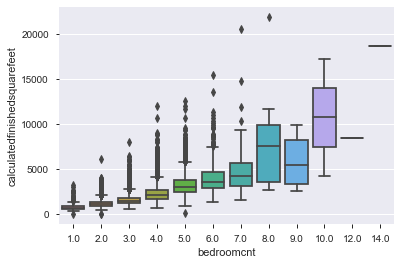

In [32]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

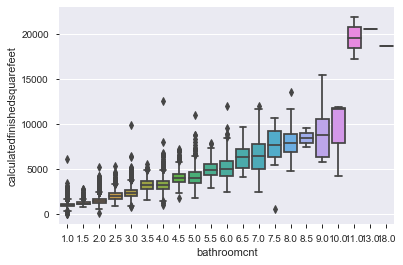

In [33]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [32]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
train.shape

(34674, 14)

In [33]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
test.shape

(14854, 14)

### Convert dtypes to category for the cols below

- train_cat and test_cat are subsets with dtypes converted to category for the following columns:

    - "bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"
    
- train_cat and test_cat also have outliers handled and no missing values.

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34674 entries, 3467 to 15729
Data columns (total 14 columns):
tax_rate               34674 non-null float64
bathroomcnt            34674 non-null float64
bedroomcnt             34674 non-null float64
fips                   34674 non-null float64
garagecarcnt           34674 non-null float64
latitude               34674 non-null float64
longitude              34674 non-null float64
poolcnt                34674 non-null float64
yearbuilt              34674 non-null float64
logerror               34674 non-null float64
county_name            34674 non-null object
price_per_sq_ft        34674 non-null float64
lot_price_per_sq_ft    34674 non-null float64
cluster                34674 non-null object
dtypes: float64(12), object(2)
memory usage: 4.0+ MB


In [35]:
cols = ["bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"]

In [36]:
train_cat = prepare.numeric_to_category(train, cols)

In [37]:
test_cat = prepare.numeric_to_category(test, cols)

In [38]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34674 entries, 3467 to 15729
Data columns (total 14 columns):
tax_rate               34674 non-null float64
bathroomcnt            34674 non-null category
bedroomcnt             34674 non-null category
fips                   34674 non-null float64
garagecarcnt           34674 non-null category
latitude               34674 non-null float64
longitude              34674 non-null float64
poolcnt                34674 non-null category
yearbuilt              34674 non-null category
logerror               34674 non-null float64
county_name            34674 non-null category
price_per_sq_ft        34674 non-null float64
lot_price_per_sq_ft    34674 non-null float64
cluster                34674 non-null object
dtypes: category(6), float64(7), object(1)
memory usage: 2.6+ MB


In [39]:
train.bedroomcnt.value_counts()

3.00    16152
4.00    10372
2.00     5885
5.00     2265
Name: bedroomcnt, dtype: int64

In [40]:
train.bathroomcnt.value_counts()

2.00    15190
3.00     7292
1.00     6314
2.50     2756
4.00     1427
3.50      649
1.50      595
4.50      451
Name: bathroomcnt, dtype: int64

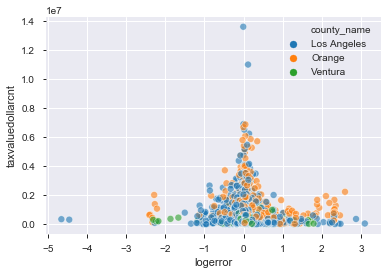

In [43]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

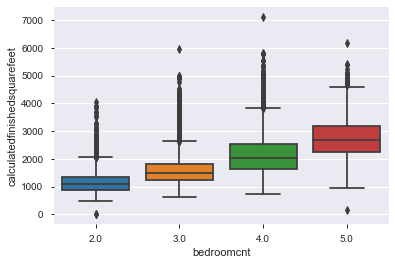

In [44]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

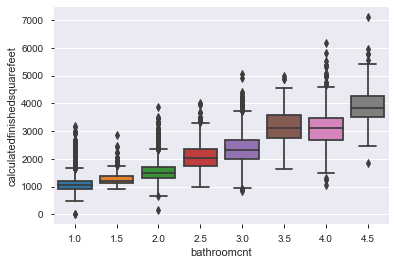

In [45]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [46]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt)
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.00,3413,103,1619,127,149,8,5,0
3.00,2451,295,8706,1274,1838,124,172,20
4.00,149,71,3576,1080,3142,278,446,162
5.00,19,1,216,114,883,82,311,148


In [47]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [48]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 0.0.


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [49]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt)
contingency_table

poolcnt,0.0,1.0
garagecarcnt,,
0.00,16834,3109
1.00,1244,140
2.00,7465,1947
3.00,121,78
4.00,22,17
5.00,2,0
6.00,2,0
10.00,1,0


In [50]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [51]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 3.4502756484518547e-51.


In [52]:
r, p = stats.pearsonr(train_cat.lotsizesquarefeet, train_cat.taxvaluedollarcnt)

In [53]:
print(f"r is {r}")

r is 0.0692340188254389


In [54]:
print(f"p is {p}")

p is 3.0885831609595475e-34


In [36]:
# creating df handling values above 10_000 sqfeet to get a better look at the relationship between the variables

lot_no_outliers = train_cat[train_cat.lotsizesquarefeet > 10000]

AttributeError: 'DataFrame' object has no attribute 'lotsizesquarefeet'

### DB Scan this thingy

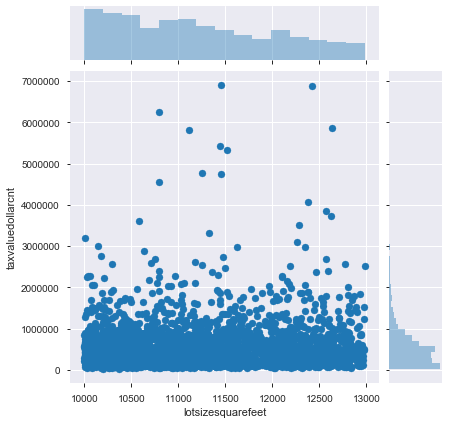

In [56]:
sns.jointplot(data=lot_no_outliers, y="taxvaluedollarcnt", x="lotsizesquarefeet")

## Split train and test into X_train, X_test, y_train, y_test

In [43]:
train = train.drop(columns='county_name')
test = test.drop(columns='county_name')

In [44]:
X_train = train.drop(columns="logerror")

y_train = train[["logerror"]]

X_test = test.drop(columns="logerror")

y_test = test[["logerror"]]

In [45]:
X_train.head()

,tax_rate,bathroomcnt,bedroomcnt,fips,garagecarcnt,latitude,longitude,poolcnt,yearbuilt,price_per_sq_ft,...,90,91,92,93,94,95,96,97,98,99
3467,0.01,3.00,4.00,"6,059.00",2.00,33.67,-117.94,1.00,"1,964.00",168.24,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5575,0.01,2.00,5.00,"6,037.00",0.00,33.93,-118.04,0.00,"1,952.00",310.34,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43540,0.01,1.00,2.00,"6,037.00",0.00,34.14,-118.36,0.00,"1,940.00",214.92,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25190,0.01,2.00,4.00,"6,059.00",2.00,33.62,-117.91,1.00,"1,956.00",686.59,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
22482,0.01,2.00,3.00,"6,037.00",0.00,34.20,-118.23,0.00,"1,947.00",138.74,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Model df - Random Forest

In [41]:
train, ohe = prepare.encode(df=train, col_name='cluster')
train = train.drop(columns='cluster')

In [42]:
test, ohe = prepare.encode(df=test, col_name='cluster')
test = test.drop(columns='cluster')

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [47]:
rf = RandomForestRegressor(n_estimators=10)

In [79]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [48]:
train_cols = train.columns
test_cols = test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

In [52]:
train.shape

(34674, 101)

In [53]:
test.shape

(14854, 103)

In [51]:
train = train.drop(columns=train_not_test)

In [80]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

root mean squared error = 0.0029875149796885314


In [81]:
y_pred = rf.predict(X_test)
print(f'root mean squared error = {mean_squared_error(y_test, y_pred)**1/2}')

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 104 

### PUT TAKEAWAYS FROM RANDOM FOREST MODEL HERE
random forest is da best

Try using this same model with different bins.  Try binning by year sold and by geographical location (lat/long, $/sqft)

- Our best model for predicting log error
- has a root mean squared error of .0019


## Model - Linear Regression Model

In [64]:
X_train.dtypes

tax_rate                         float64
bathroomcnt                     category
bedroomcnt                      category
calculatedfinishedsquarefeet     float64
fips                             float64
garagecarcnt                    category
latitude                         float64
longitude                        float64
lotsizesquarefeet                float64
poolcnt                         category
taxvaluedollarcnt                float64
yearbuilt                       category
landtaxvaluedollarcnt            float64
los_angeles                      float64
ventura                          float64
orange                           float64
dtype: object

In [65]:
X_train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,los_angeles,ventura,orange
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,"143,427.00","1,955.00","88,553.00",1.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,"87,511.00","1,957.00","16,333.00",0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",1.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,"644,000.00","2,003.00","330,000.00",0.00,1.00,0.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.00,1.00,0.00


In [66]:
X_train.garagecarcnt = X_train.garagecarcnt.astype(float)
X_train.bathroomcnt = X_train.bathroomcnt.astype(float)
X_train.bedroomcnt = X_train.bedroomcnt.astype(float)
X_train.poolcnt = X_train.poolcnt.astype(float)

In [67]:
X_train = X_train.drop(columns='yearbuilt')
X_test = X_test.drop(columns='yearbuilt')

In [68]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [69]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [70]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
type(yhat)
yhat

array([[0.02212469],
       [0.02463533],
       [0.02224562],
       ...,
       [0.0126673 ],
       [0.01772992],
       [0.02733914]])

In [71]:
actual = y_train
actual.head()

,logerror
22620,-0.08
35532,-0.04
17905,0.03
49147,0.07
43935,0.08


In [72]:
actual['yhat'] = yhat

### Evaluate LR Model

In [73]:
actual["residual"] = actual["yhat"] - actual["logerror"]

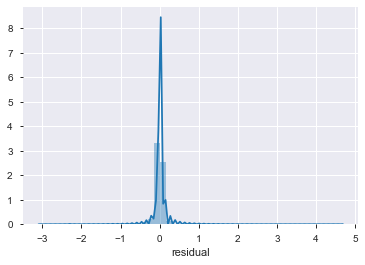

In [74]:
sns.distplot(actual["residual"])

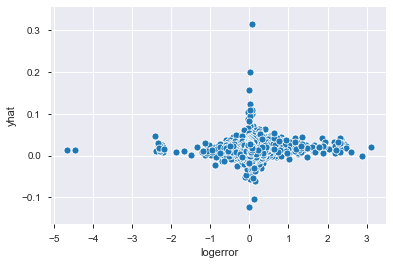

In [75]:
sns.scatterplot(actual["logerror"], actual["yhat"])

In [76]:
actual["residual^2"] = actual["residual"] ** 2

In [77]:
sse = sum(actual["residual^2"])
print(f"sse = {sse}")
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

sse = 845.9876779959633
mse = 0.02730578006571439
rmse = 0.16524460676740524


In [78]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

,metric,model_error
0,SSE,845.99
1,MSE,0.03
2,RMSE,0.17


- Create a numpy array from the y_df_nums_train df, so I can run eval metrics using yhat(prediction array) and y_array (array of actual y values)

In [79]:
y_array = np.array(y_train)
type(y_array)

numpy.ndarray

In [80]:
r2_score(actual.logerror, actual.yhat)

0.0039849208977780215

In [81]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

linear model
  mean squared error: 0.0273
  0.40% of the variance in the logerror can be explained by variables.


### Takeaways from the Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

### Model - K Neighbors Regressor

In [82]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [83]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [84]:
yhat = neigh.predict(X_train)
type(yhat)

numpy.ndarray

In [85]:
r2 = neigh.score(X_train, y_train)

In [86]:
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

  44.06% of the variance in the logerror can be explained by variables.


### Takeaways from KNRegressor Model

- This model explained more than 50% more of the variance in logerror than my LR model using exactly the same data.

- The subset of data I used was comprised of the numeric values only from the original dataframe.

- I think this model could do even better with outliers handled and some feature engineering.